In [311]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import importlib

import compare_rates
importlib.reload(compare_rates)

<module 'compare_rates' from '/Users/kelley/Projects/PhasingFamilies/parameter_estimation/compare_rates.py'>

In [312]:
chroms = [str(i) for i in range(1, 23)]

gens = ['0/0', '0/1', '1/1']
obss = ['0/0', '0/1', '1/1', './.']

# Population distributions

In [367]:
ihart_samples = compare_rates.pull_samples('../split_gen_ihart', chroms)
ihart32_samples = compare_rates.pull_samples('../split_gen_ihart3.2', chroms)

spark_exome_samples = compare_rates.pull_samples('../split_gen_spark_exome', chroms)
spark_samples = compare_rates.pull_samples('../split_gen_spark', chroms)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 3 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 3 individuals involved in multiple generations
Removing 700 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data


In [375]:
ihart_error_rates = compare_rates.pull_error_rates(ihart_samples, 'ihart_lb_params.json', chroms, gens, obss)
ihart32_error_rates = compare_rates.pull_error_rates(ihart32_samples, 'ihart3.2_lb_params.json', chroms, gens, obss)

spark_error_rates = compare_rates.pull_error_rates(spark_samples, 'spark_lb_params.json', chroms, gens, obss)

ihart_LCR_error_rates = compare_rates.pull_error_rates(ihart_samples, 'ihart_LCR_lb_params.json', chroms, gens, obss)
ihart_HCR_error_rates = compare_rates.pull_error_rates(ihart_samples, 'ihart_HCR_lb_params.json', chroms, gens, obss)
ihart_EX_error_rates = compare_rates.pull_error_rates(ihart_samples, 'ihart_EX_lb_params.json', chroms, gens, obss)


In [315]:
spark_exome_EX_error_rates = compare_rates.pull_error_rates(spark_exome_samples, 'spark_exome_EX_lb_params.json', chroms, gens, obss)


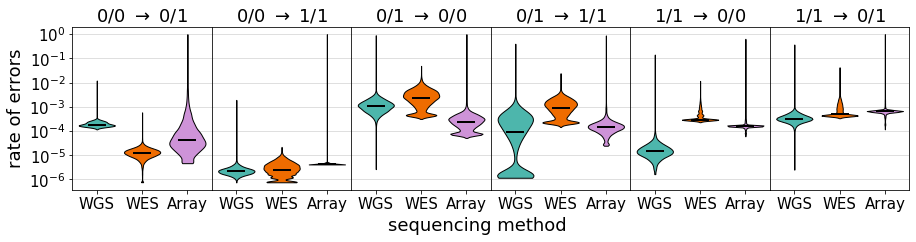

In [369]:

#prop_cycle = plt.rcParams['axes.prop_cycle']
#colors = prop_cycle.by_key()['color']
#colors = ['#4db6ac', '#ef6c00', '#695d46', '#a1e8d9', '#ff9800', '#b3a77d', '#009668', '#ce93d8', '#cedd38']
colors = ['#4db6ac', '#ef6c00', '#ce93d8', '#695d46', '#009668', '#b3a77d', '#cedd38']

errors_of_interest = [('0/0', '0/1'), ('0/0', '1/1'),
                      ('0/1', '0/0'), ('0/1', '1/1'), 
                      ('1/1', '0/0'), ('1/1', '0/1'),
                      #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                            ]
fig, subs = plt.subplots(1, len(errors_of_interest), sharey=True, figsize=(15, 3))
fig.suptitle('sequencing method', y=0, fontsize=18)

for i, (g, o) in enumerate(errors_of_interest):
    g_index, o_index = gens.index(g), obss.index(o) 
    error_rates1 = -ihart_error_rates[:, g_index, o_index]
    error_rates1 = error_rates1[ihart_samples.is_child & ~np.isnan(error_rates1)]
    
    error_rates2 = -spark_exome_EX_error_rates[:, g_index, o_index]
    error_rates2 = error_rates2[spark_exome_samples.is_child & ~np.isnan(error_rates2)]
    
    error_rates3 = -spark_error_rates[:, g_index, o_index]
    error_rates3 = error_rates3[spark_samples.is_child & ~np.isnan(error_rates3)]
         
    parts = subs[i].violinplot([error_rates1, error_rates2, error_rates3],
               showmedians=True, showextrema=False, widths=0.8)
    
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    parts['cmedians'].set_edgecolor('black')
    parts['cmedians'].set_linewidth(2)
    
    if i == 0:
        subs[i].set_ylabel('rate of errors', fontsize=18)
        subs[i].set_yticklabels(['$10^{%0.0f}$' % f for f in subs[i].get_yticks()], {'fontsize': 15})
    else:
        subs[i].tick_params('y', length=0)
    subs[i].set_title(r'%s $\rightarrow$ %s' % (g, ' ./.  ' if o=='./.' else o), {'fontsize': 18})
    subs[i].set_xticklabels(['', 'WGS', 'WES', 'Array'], {'fontsize': 15})
    subs[i].grid(True, axis='y', alpha=0.5)
    subs[i].set_axisbelow(True)
fig.subplots_adjust(wspace=0.0)


#plt.tight_layout()
#plt.savefig('../plots/sequencing_method.png')
plt.show()

In [370]:
def calculate_precision_recall(error_rates, baseline_counts):
    # precision: TP/(TP + FP)
    # let n_0 = # of times the real genotype is 0/0
    # E[TP] = n_1 * p_11
    # E[FP] = n_0 * p_01
    precisions = []
    recalls = []
    for gen_index, gen in enumerate(gens):
        error_counts = baseline_counts[:, :3]*(10.0**-error_rates[:, :, obss.index(gen)])
        TP = error_counts[:, gen_index]
        FP = np.sum(error_counts, axis=1)-TP
        FN = baseline_counts[:, gen_index]*(1-(10.00**-error_rates[:, gen_index, obss.index(gen)]))
 
        precisions.append(TP/(TP+FP))
        recalls.append(TP/(TP+FN))
        
    return precisions[1], recalls[1], precisions[2], recalls[2]
    

In [376]:
ihart_baseline_counts = np.load('../split_gen_ihart/baseline_counts.npy')
ihart32_baseline_counts = np.load('../split_gen_ihart3.2/baseline_counts.npy')
spark_exome_EX_baseline_counts = np.load('../split_gen_spark_exome_EX/baseline_counts.npy')
spark_baseline_counts = np.load('../split_gen_spark/baseline_counts.npy')


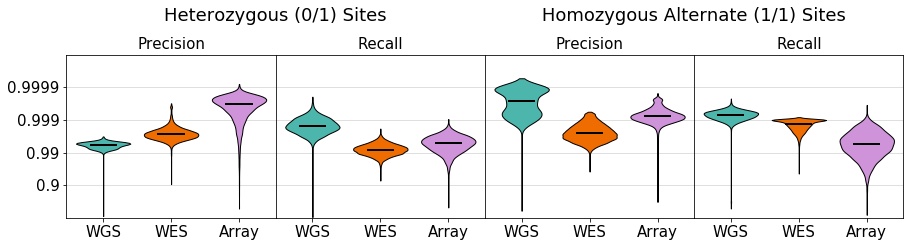

In [377]:
colors = ['#4db6ac', '#ef6c00', '#ce93d8', '#695d46', '#009668', '#b3a77d', '#cedd38']

fig, subs = plt.subplots(1, 4, sharey=True, figsize=(15, 3))
fig.suptitle('Heterozygous (0/1) Sites                           Homozygous Alternate (1/1) Sites', 
             fontsize=18, x=0.215, y=1.1, horizontalalignment='left')

for i, (x, y, z) in enumerate(zip(list(calculate_precision_recall(ihart_error_rates, ihart_baseline_counts)),
                   list(calculate_precision_recall(spark_exome_EX_error_rates, spark_exome_EX_baseline_counts)),
                   list(calculate_precision_recall(spark_error_rates, spark_baseline_counts)))):
    
    parts = subs[i].violinplot([-np.log10(1-x[ihart_samples.is_child & ~np.isnan(x)]), 
                                -np.log10(1-y[spark_exome_samples.is_child & ~np.isnan(y)]),
                                -np.log10(1-z[spark_samples.is_child & ~np.isnan(z)])],
               showmedians=True, showextrema=False, widths=0.8)
    
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    parts['cmedians'].set_edgecolor('black')
    parts['cmedians'].set_linewidth(2)
    
    if i == 0:
        #subs[i].set_ylabel('rate of errors', fontsize=18)
        subs[i].set_yticks(np.arange(1, 5))
        subs[i].set_yticklabels(['0.' + '9'*int(f) % f for f in subs[i].get_yticks()], {'fontsize': 15})
    else:
        subs[i].tick_params('y', length=0)
    subs[i].set_title(['Precision', 'Recall', 'Precision', 'Recall'][i], {'fontsize': 15})
    subs[i].set_xticks(np.arange(1, 4))
    subs[i].set_xticklabels(['WGS', 'WES', 'Array'], {'fontsize': 15})
    subs[i].grid(True, axis='y', alpha=0.5)
    subs[i].set_axisbelow(True)
    subs[i].set_ylim([0, 5])

fig.subplots_adjust(wspace=0.0)
plt.show()

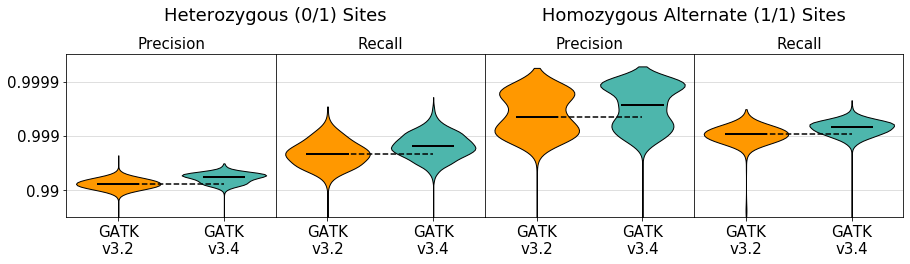

In [410]:
#'#4db6ac', '#ef6c00', '#695d46', '#a1e8d9', '#ff9800', '#b3a77d', '#009668'
colors = ['#ff9800', '#4db6ac', '#ce93d8', '#695d46', '#009668', '#b3a77d', '#cedd38']

fig, subs = plt.subplots(1, 4, sharey=True, figsize=(15, 3))
fig.suptitle('Heterozygous (0/1) Sites                           Homozygous Alternate (1/1) Sites', 
             fontsize=18, x=0.215, y=1.1, horizontalalignment='left')

for i, (x, y) in enumerate(zip(list(calculate_precision_recall(ihart32_error_rates, ihart32_baseline_counts)),
                   list(calculate_precision_recall(ihart_error_rates, ihart_baseline_counts)))):
    
    parts = subs[i].violinplot([-np.log10(1-x[ihart32_samples.is_child & ~np.isnan(x)]), 
                                -np.log10(1-y[ihart_samples.is_child & ~np.isnan(y)])],
               showmedians=True, showextrema=False, widths=0.8)
    subs[i].plot(range(1, 3), [np.median(-np.log10(1-x[ihart32_samples.is_child & ~np.isnan(x)]))]*2, color='black', linestyle='--')
    
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    parts['cmedians'].set_edgecolor('black')
    parts['cmedians'].set_linewidth(2)
    
    if i == 0:
        #subs[i].set_ylabel('rate of errors', fontsize=18)
        subs[i].set_yticks(np.arange(1, 5))
        subs[i].set_yticklabels(['0.' + '9'*int(f) % f for f in subs[i].get_yticks()], {'fontsize': 15})
    else:
        subs[i].tick_params('y', length=0)
    subs[i].set_title(['Precision', 'Recall', 'Precision', 'Recall'][i], {'fontsize': 15})
    subs[i].set_xticks(np.arange(1, 3))
    subs[i].set_xticklabels(['GATK\nv3.2', 'GATK\nv3.4'], {'fontsize': 15})
    subs[i].grid(True, axis='y', alpha=0.5)
    subs[i].set_axisbelow(True)
    subs[i].set_ylim([1.5, 4.5])

fig.subplots_adjust(wspace=0.0)
plt.show()

807


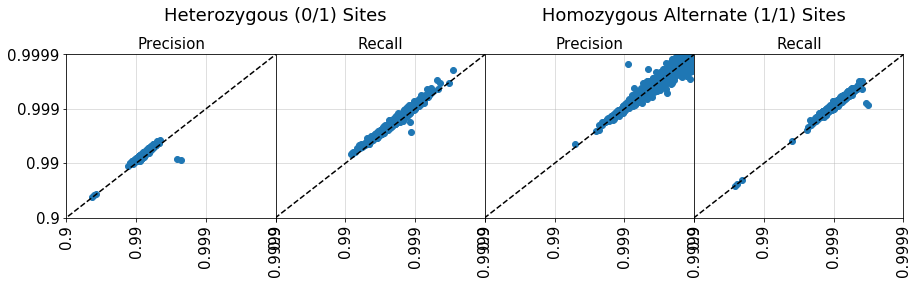

In [395]:
colors = ['#4db6ac', '#ef6c00', '#ce93d8', '#695d46', '#009668', '#b3a77d', '#cedd38']


v34_precision1, v34_recall1, v34_precision2, v34_recall2 = calculate_precision_recall(ihart_error_rates, ihart_baseline_counts)
v32_precision1, v32_recall1, v32_precision2, v32_recall2 = calculate_precision_recall(ihart32_error_rates, ihart32_baseline_counts)

v34_samples = set([x for x, is_child in zip(ihart_samples.sample_ids, ihart_samples.is_child) if is_child])
v32_samples = set([x for x, is_child in zip(ihart32_samples.sample_ids, ihart32_samples.is_child) if is_child])

overlap = sorted(v34_samples & v32_samples)
print(len(overlap))

v34_indices = [ihart_samples.sample_ids.index(x) for x in overlap]
v32_indices = [ihart32_samples.sample_ids.index(x) for x in overlap]

fig, subs = plt.subplots(1, 4, sharey=True, figsize=(15, 3))
fig.suptitle('Heterozygous (0/1) Sites                           Homozygous Alternate (1/1) Sites', 
                 fontsize=18, x=0.215, y=1.1, horizontalalignment='left')
    
for i, (v32_data, v34_data) in enumerate(zip([v32_precision1, v32_recall1, v32_precision2, v32_recall2],
                             [v34_precision1, v34_recall1, v34_precision2, v34_recall2])):
    

    subs[i].scatter(-np.log10(1-v32_data[v32_indices]), -np.log10(1-v34_data[v34_indices]))
    subs[i].plot([0, 5], [0, 5], color='black', linestyle='--')
    
    if i == 0:
        #subs[i].set_ylabel('rate of errors', fontsize=18)
        subs[i].set_yticks(np.arange(1, 5))
        subs[i].set_yticklabels(['0.' + '9'*int(f) % f for f in subs[i].get_yticks()], {'fontsize': 15})
    else:
        subs[i].tick_params('y', length=0)
    
    subs[i].set_title(['Precision', 'Recall', 'Precision', 'Recall'][i], {'fontsize': 15})
    
    subs[i].grid(True, axis='both', alpha=0.5)
    subs[i].set_axisbelow(True)
    subs[i].set_xlim([1, 4])
    subs[i].set_ylim([1, 4])
    subs[i].set_xticks(np.arange(1, 5))
    subs[i].set_xticklabels(['0.' + '9'*int(f) % f for f in subs[i].get_yticks()], {'fontsize': 15})
    for tick in subs[i].get_xticklabels():
        tick.set_rotation(90)

fig.subplots_adjust(wspace=0.0)
plt.show()

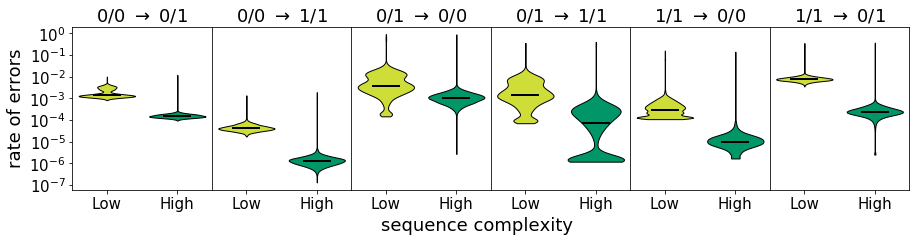

In [273]:

#prop_cycle = plt.rcParams['axes.prop_cycle']
#colors = prop_cycle.by_key()['color']
#colors = ['#4db6ac', '#ef6c00', '#695d46', '#a1e8d9', '#ff9800', '#b3a77d', '#009668', '#ce93d8', '#cedd38']
colors = ['#cedd38', '#009668']

errors_of_interest = [('0/0', '0/1'), ('0/0', '1/1'),
                      ('0/1', '0/0'), ('0/1', '1/1'), 
                      ('1/1', '0/0'), ('1/1', '0/1'),
                      #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                            ]
fig, subs = plt.subplots(1, len(errors_of_interest), sharey=True, figsize=(15, 3))
fig.suptitle('sequence complexity', y=0, fontsize=18)

for i, (g, o) in enumerate(errors_of_interest):
    g_index, o_index = gens.index(g), obss.index(o) 
    error_rates1 = -ihart_LCR_error_rates[:, g_index, o_index]
    error_rates1 = error_rates1[ihart_samples.is_child & ~np.isnan(error_rates1)]
    
    error_rates4 = -ihart_HCR_error_rates[:, g_index, o_index]
    error_rates4 = error_rates4[ihart_samples.is_child & ~np.isnan(error_rates4)]
         
    parts = subs[i].violinplot([error_rates1, error_rates4],
               showmedians=True, showextrema=False, widths=0.8)
    
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    parts['cmedians'].set_edgecolor('black')
    parts['cmedians'].set_linewidth(2)
    
    if i == 0:
        subs[i].set_ylabel('rate of errors', fontsize=18)
        subs[i].set_yticks(np.arange(-7, 1))
        subs[i].set_yticklabels(['$10^{%0.0f}$' % f for f in subs[i].get_yticks()], {'fontsize': 15})
    else:
        subs[i].tick_params('y', length=0)
    subs[i].set_title(r'%s $\rightarrow$ %s' % (g, ' ./.  ' if o=='./.' else o), {'fontsize': 18})
    subs[i].set_xticks(np.arange(1, 3))
    subs[i].set_xticklabels(['Low', 'High'], {'fontsize': 15})

fig.subplots_adjust(wspace=0.0)
#plt.savefig('../plots/lcr.png')
plt.show()

In [274]:
ihart_LCR_baseline_counts = np.load('../split_gen_ihart_LCR/baseline_counts.npy')
ihart_HCR_baseline_counts = np.load('../split_gen_ihart_HCR/baseline_counts.npy')
ihart_EX_baseline_counts = np.load('../split_gen_ihart_EX/baseline_counts.npy')


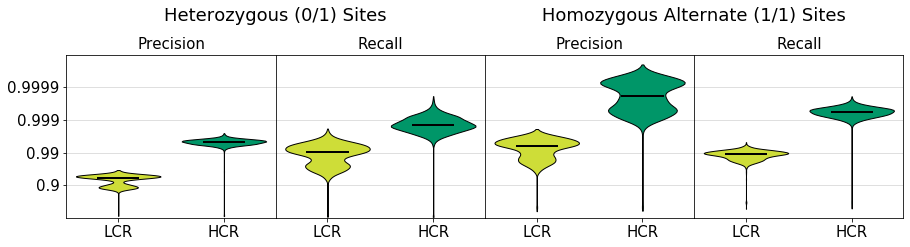

In [347]:
colors = ['#cedd38', '#009668']

fig, subs = plt.subplots(1, 4, sharey=True, figsize=(15, 3))
fig.suptitle('Heterozygous (0/1) Sites                           Homozygous Alternate (1/1) Sites', 
             fontsize=18, x=0.215, y=1.1, horizontalalignment='left')

for i, (x, y) in enumerate(zip(list(calculate_precision_recall(ihart_LCR_error_rates, ihart_LCR_baseline_counts)),
                   list(calculate_precision_recall(ihart_HCR_error_rates, ihart_HCR_baseline_counts)),
                   )):

    parts = subs[i].violinplot([-np.log10(1-x[ihart_samples.is_child & ~np.isnan(x)]), 
                                -np.log10(1-y[ihart_samples.is_child & ~np.isnan(y)])],
               showmedians=True, showextrema=False, widths=0.8)
    
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    parts['cmedians'].set_edgecolor('black')
    parts['cmedians'].set_linewidth(2)
    
    if i == 0:
        #subs[i].set_ylabel('rate of errors', fontsize=18)
        subs[i].set_yticks(np.arange(1, 5))
        subs[i].set_yticklabels(['0.' + '9'*int(f) % f for f in subs[i].get_yticks()], {'fontsize': 15})
    else:
        subs[i].tick_params('y', length=0)
    subs[i].set_title(['Precision', 'Recall', 'Precision', 'Recall'][i], {'fontsize': 15})
    subs[i].set_xticks(np.arange(1, 3))
    subs[i].set_xticklabels(['LCR', 'HCR'], {'fontsize': 15})
    subs[i].grid(True, axis='y', alpha=0.5)
    subs[i].set_axisbelow(True)
    subs[i].set_ylim([0, 5])

fig.subplots_adjust(wspace=0.0)
#plt.savefig('../plots/lcr.png')
plt.show()

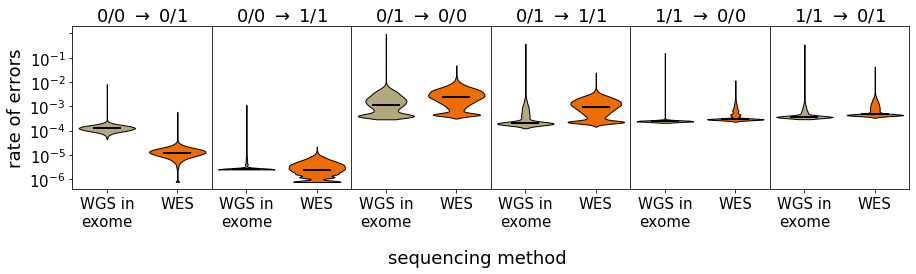

In [341]:

#prop_cycle = plt.rcParams['axes.prop_cycle']
#colors = prop_cycle.by_key()['color']
#colors = ['#4db6ac', '#ef6c00', '#695d46', '#a1e8d9', '#ff9800', '#b3a77d', '#009668', '#ce93d8', '#cedd38']
colors = ['#b3a77d', '#ef6c00']

errors_of_interest = [('0/0', '0/1'), ('0/0', '1/1'),
                      ('0/1', '0/0'), ('0/1', '1/1'), 
                      ('1/1', '0/0'), ('1/1', '0/1'),
                      #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                            ]
fig, subs = plt.subplots(1, len(errors_of_interest), sharey=True, figsize=(15, 3))
fig.suptitle('sequencing method', y=-0.15, fontsize=18)

for i, (g, o) in enumerate(errors_of_interest):
    g_index, o_index = gens.index(g), obss.index(o) 
    error_rates1 = -ihart_EX_error_rates[:, g_index, o_index]
    indices1 = ihart_samples.is_child & ~np.isnan(error_rates1)
    error_rates1 = error_rates1
    
    error_rates2 = -spark_exome_EX_error_rates[:, g_index, o_index]
    indices2 = spark_exome_samples.is_child & ~np.isnan(error_rates2)
    error_rates2 = error_rates2
    
    #print(np.nanmedian(error_counts1[indices1])-np.nanmedian(error_counts2[indices2]))
    parts = subs[i].violinplot([error_rates1[indices1], error_rates2[indices2]],
               showmedians=True, showextrema=False, widths=0.8)
    
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    parts['cmedians'].set_edgecolor('black')
    parts['cmedians'].set_linewidth(2)
    
    if i == 0:
        subs[i].set_ylabel('rate of errors', fontsize=18)
        #subs[i].set_yticks(np.arange(-7, 1))
        subs[i].set_yticklabels(['$10^{%0.0f}$' % f for f in subs[i].get_yticks()], {'fontsize': 15})
    else:
        subs[i].tick_params('y', length=0)
    subs[i].set_title(r'%s $\rightarrow$ %s' % (g, ' ./.  ' if o=='./.' else o), {'fontsize': 18})
    subs[i].set_xticks(np.arange(1, 3))
    subs[i].set_xticklabels(['WGS in\nexome', 'WES'], {'fontsize': 15})


fig.subplots_adjust(wspace=0.0)


#plt.tight_layout()
plt.savefig('../plots/wgs_vs_wes.png')
plt.show()

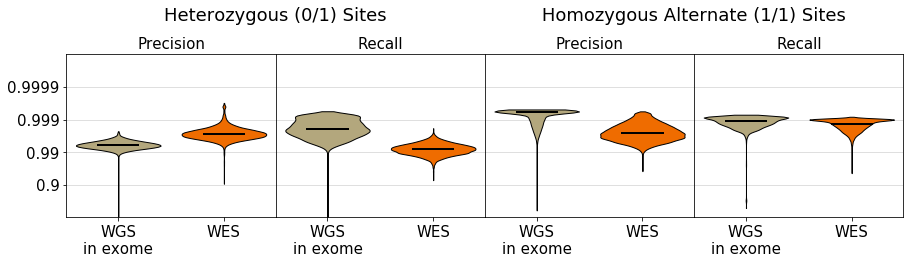

In [348]:
colors = ['#b3a77d', '#ef6c00']

fig, subs = plt.subplots(1, 4, sharey=True, figsize=(15, 3))
fig.suptitle('Heterozygous (0/1) Sites                           Homozygous Alternate (1/1) Sites', 
             fontsize=18, x=0.215, y=1.1, horizontalalignment='left')

for i, (x, y) in enumerate(zip(list(calculate_precision_recall(ihart_EX_error_rates, ihart_EX_baseline_counts)),
                   list(calculate_precision_recall(spark_exome_EX_error_rates, spark_exome_EX_baseline_counts)),
                   )):

    parts = subs[i].violinplot([-np.log10(1-x[ihart_samples.is_child & ~np.isnan(x)]), 
                                -np.log10(1-y[spark_exome_samples.is_child & ~np.isnan(y)])],
               showmedians=True, showextrema=False, widths=0.8)
    
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    parts['cmedians'].set_edgecolor('black')
    parts['cmedians'].set_linewidth(2)
    
    if i == 0:
        #subs[i].set_ylabel('rate of errors', fontsize=18)
        subs[i].set_yticks(np.arange(1, 5))
        subs[i].set_yticklabels(['0.' + '9'*int(f) % f for f in subs[i].get_yticks()], {'fontsize': 15})
    else:
        subs[i].tick_params('y', length=0)
    subs[i].set_title(['Precision', 'Recall', 'Precision', 'Recall'][i], {'fontsize': 15})
    subs[i].set_xticks(np.arange(1, 3))
    subs[i].set_xticklabels(['WGS\nin exome', 'WES'], {'fontsize': 15})
    subs[i].grid(True, axis='y', alpha=0.5)
    subs[i].set_axisbelow(True)
    subs[i].set_ylim([0, 5])
    
fig.subplots_adjust(wspace=0.0)
#plt.savefig('../plots/lcr.png')
plt.show()

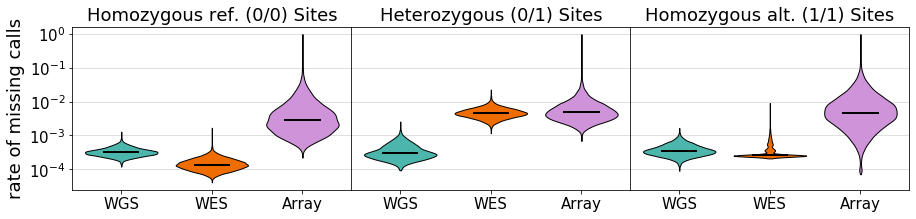

In [343]:

#prop_cycle = plt.rcParams['axes.prop_cycle']
#colors = prop_cycle.by_key()['color']
#colors = ['#4db6ac', '#ef6c00', '#695d46', '#a1e8d9', '#ff9800', '#b3a77d', '#009668', '#ce93d8', '#cedd38']
colors = ['#4db6ac', '#ef6c00', '#ce93d8', '#695d46', '#009668', '#b3a77d', '#cedd38']

errors_of_interest = [('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                            ]
fig, subs = plt.subplots(1, len(errors_of_interest), sharey=True, figsize=(15, 3))

for i, (g, o) in enumerate(errors_of_interest):
    g_index, o_index = gens.index(g), obss.index(o) 
    error_rates1 = -ihart_error_rates[:, g_index, o_index]
    error_rates1 = error_rates1[ihart_samples.is_child & ~np.isnan(error_rates1)]
    
    error_rates2 = -spark_exome_EX_error_rates[:, g_index, o_index]
    error_rates2 = error_rates2[spark_exome_samples.is_child & ~np.isnan(error_rates2)]
    
    error_rates3 = -spark_error_rates[:, g_index, o_index]
    error_rates3 = error_rates3[spark_samples.is_child & ~np.isnan(error_rates3)]
     
    parts = subs[i].violinplot([error_rates1, error_rates2, error_rates3],
               showmedians=True, showextrema=False, widths=0.8)
    
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    parts['cmedians'].set_edgecolor('black')
    parts['cmedians'].set_linewidth(2)
    
    if i == 0:
        subs[i].set_ylabel('rate of missing calls', fontsize=18)
        subs[i].set_yticklabels(['$10^{%0.0f}$' % f for f in subs[i].get_yticks()], {'fontsize': 15})
    else:
        subs[i].tick_params('y', length=0)
    subs[i].set_title(['Homozygous ref. (0/0) Sites', 'Heterozygous (0/1) Sites', 'Homozygous alt. (1/1) Sites'][i], {'fontsize': 18})
    subs[i].set_xticks(np.arange(1, 4))
    subs[i].set_xticklabels(['WGS', 'WES', 'Array'], {'fontsize': 15})
    subs[i].grid(True, axis='y', alpha=0.5)
    subs[i].set_axisbelow(True)
    
fig.subplots_adjust(wspace=0.0)
plt.savefig('../plots/missing_calls.png')
#plt.show()

# Exome distance from target

In [351]:
all_samples = [spark_exome_samples]
all_error_rates = [spark_exome_EX_error_rates]
all_baseline_counts = [spark_exome_EX_baseline_counts]
for w in [25, 50, 75, 1000]:
    samples = compare_rates.pull_samples('../split_gen_spark_exome_EX%d' % w, chroms)
    all_samples.append(samples)
    
    baseline_counts = np.load('../split_gen_spark_exome_EX%d/baseline_counts.npy' % w)
    all_baseline_counts.append(baseline_counts)

    error_rates = compare_rates.pull_error_rates(samples, 'spark_exome_EX%d_lb_params.json' % w, chroms, gens, obss)
    all_error_rates.append(error_rates)
    
    
    


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data


['1.00', '1.07', '1.33', '1.76', '1.95']
['1.00', '1.13', '1.11', '1.22', '1.07']
['1.00', '0.94', '1.76', '3.29', '3.89']
['1.00', '1.16', '2.58', '5.74', '7.32']
['1.00', '2.42', '2.22', '2.54', '3.10']
['1.00', '2.81', '6.38', '16.08', '17.98']


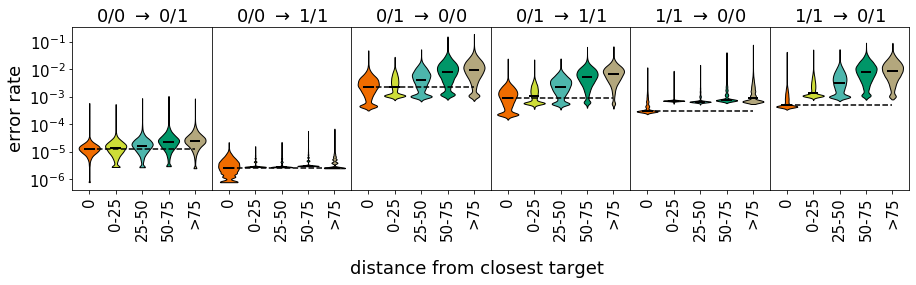

In [411]:

#prop_cycle = plt.rcParams['axes.prop_cycle']
#colors = prop_cycle.by_key()['color']
#colors = ['#4db6ac', '#ef6c00', '#695d46', '#a1e8d9', '#ff9800', '#b3a77d', '#009668', '#ce93d8', '#cedd38']
colors = ['#ef6c00', '#cedd38', '#4db6ac', '#009668', '#b3a77d', ]

errors_of_interest = [('0/0', '0/1'), ('0/0', '1/1'),
                      ('0/1', '0/0'), ('0/1', '1/1'), 
                      ('1/1', '0/0'), ('1/1', '0/1'),
                    #('0/1', './.'), ('1/1', './.')
                            ]
fig, subs = plt.subplots(1, len(errors_of_interest), sharey=True, figsize=(15, 3))
fig.suptitle('distance from closest target', y=-0.2, fontsize=18)



for i, (g, o) in enumerate(errors_of_interest):
    g_index, o_index = gens.index(g), obss.index(o) 
    
    to_plot = []
    for samples, error_rates in zip(all_samples, all_error_rates):
        add_plot = -error_rates[samples.is_child, g_index, o_index]
        add_plot = add_plot[~np.isnan(add_plot)]
        to_plot.append(add_plot)
             
    parts = subs[i].violinplot(to_plot,
               showmedians=True, showextrema=False, widths=0.8)
    
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    parts['cmedians'].set_edgecolor('black')
    parts['cmedians'].set_linewidth(2)
        
    #subs[i].plot(range(1, 5), [np.median(x) for x in to_plot], color='black')
    subs[i].plot(range(1, 6), [np.median(to_plot[0])]*5, color='black', linestyle='--')
    print(['%0.2f' % 10.0**(np.median(x)-np.median(to_plot[0])) for x in to_plot])
    
    if i == 0:
        subs[i].set_ylabel('error rate', fontsize=18)
        #subs[i].set_ylim([-7, 1])
        subs[i].set_yticks(np.arange(-6, 1))
        subs[i].set_yticklabels(['$10^{%0.0f}$' % f for f in subs[i].get_yticks()], {'fontsize': 15})
    else:
        subs[i].tick_params('y', length=0)
    subs[i].set_title(r'%s $\rightarrow$ %s' % (g, ' ./.  ' if o=='./.' else o), {'fontsize': 18})
    subs[i].set_xticks(np.arange(1, 6))
    subs[i].set_xticklabels(['0', '0-25', '25-50', '50-75', '>75'], {'fontsize': 15})
    for tick in subs[i].get_xticklabels():
        tick.set_rotation(90)

fig.subplots_adjust(wspace=0.0)


#plt.tight_layout()
#plt.savefig(filename)
plt.show()

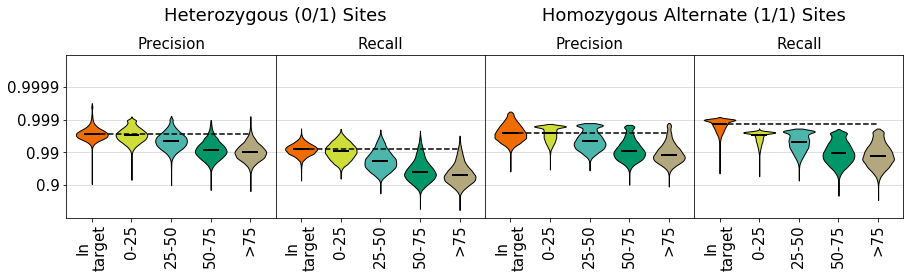

In [363]:
colors = ['#ef6c00', '#cedd38', '#4db6ac', '#009668', '#b3a77d', ]

fig, subs = plt.subplots(1, 4, sharey=True, figsize=(15, 3))
fig.suptitle('Heterozygous (0/1) Sites                           Homozygous Alternate (1/1) Sites', 
             fontsize=18, x=0.215, y=1.1, horizontalalignment='left')
for i, to_plot in enumerate(zip(list(calculate_precision_recall(all_error_rates[0], all_baseline_counts[0])),
                   list(calculate_precision_recall(all_error_rates[1], all_baseline_counts[1])),
                   list(calculate_precision_recall(all_error_rates[2], all_baseline_counts[2])),
                   list(calculate_precision_recall(all_error_rates[3], all_baseline_counts[3])),
                   list(calculate_precision_recall(all_error_rates[4], all_baseline_counts[4])) 
                   )):

    to_plot = [-np.log10(1-x[y.is_child & ~np.isnan(x)]) for x, y in zip(to_plot, all_samples)]
    
    parts = subs[i].violinplot(to_plot,
               showmedians=True, showextrema=False, widths=0.8)
    
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    parts['cmedians'].set_edgecolor('black')
    parts['cmedians'].set_linewidth(2)
    subs[i].plot(range(1, 6), [np.median(to_plot[0])]*5, color='black', linestyle='--')
    
    if i == 0:
        #subs[i].set_ylabel('rate of errors', fontsize=18)
        subs[i].set_yticks(np.arange(1, 5))
        subs[i].set_yticklabels(['0.' + '9'*int(f) % f for f in subs[i].get_yticks()], {'fontsize': 15})
    else:
        subs[i].tick_params('y', length=0)
    subs[i].set_title(['Precision', 'Recall', 'Precision', 'Recall'][i], {'fontsize': 15})
    subs[i].set_xticks(np.arange(1, 6))
    subs[i].set_xticklabels(['In\ntarget', '0-25', '25-50', '50-75', '>75'], {'fontsize': 15})
    subs[i].grid(True, axis='y', alpha=0.5)
    subs[i].set_axisbelow(True)
    subs[i].set_ylim([0, 5])
    for tick in subs[i].get_xticklabels():
        tick.set_rotation(90)
    
fig.subplots_adjust(wspace=0.0)
#plt.savefig('../plots/lcr.png')
plt.show()